# Latent Alignment Approach

In [1]:
import matplotlib.pyplot as plt
import omegaconf
import pytorch_lightning as pl
import rul_datasets
import torch
from torch.utils.data import DataLoader

import rul_adapt

## Training Preparations

The Latent Alignment uses a first-time-to-predict (FTTP) estimation approach to appropriately label the XJTU-SY dataset.
The FTTP approach uses a GAN trained only on the first few windows of each bearing which are considered healthy.
The discriminator of the GAN is used to calculate a healthy index for each window.
The FTTP is the index of the first window that exceeds a threshold defined as a multiple of the average health index of the training data.

The RUL Adapt library implements the FTTP approach but includes the results in the configuration for an easier replication process.
The GAN was trained as follows:

In [4]:
reader = rul_datasets.XjtuSyReader(
    1, run_split_dist={"dev": [1, 2, 3, 4, 5], "val": [], "test": []}
)
reader.prepare_data()
chunk_extractor = rul_adapt.approach.latent_align.ChunkWindowExtractor(5, 256)
features, targets = reader.load_split("dev")
features, targets = zip(
    *(
        chunk_extractor(feature, target)
        for feature, target in zip(features, targets)
    )
)
healthy, _ = rul_datasets.adaption.split_healthy(
    features, targets, by_steps=15 * 128
)
healthy_dl = DataLoader(healthy, batch_size=128, shuffle=True)

feature_extractor = rul_adapt.model.CnnExtractor(
    2,
    [64, 32, 16],
    features[0].shape[1],
    fc_units=512,
    act_func=torch.nn.LeakyReLU,
    fc_act_func=torch.nn.LeakyReLU,
)
regressor = rul_adapt.model.FullyConnectedHead(
    512, [1], act_func_on_last_layer=False
)
generator = rul_adapt.model.CnnExtractor(
    1,
    [64, 32, 16, 512, 2],
    features[0].shape[1],
    [10, 10, 10, 1, 1],
    padding=True,
    act_func=torch.nn.LeakyReLU,
)

approach = rul_adapt.approach.LatentAlignFttpApproach(
    features[0].shape[1], lr=1e-5
)
approach.set_model(feature_extractor, regressor, generator)

trainer = pl.Trainer(max_epochs=1)

trainer.fit(approach, healthy_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name               | Type                  | Params
-------------------------------------------------------------
0 | gan_loss           | BCEWithLogitsLoss     | 0     
1 | grl                | GradientReversalLayer | 0     
2 | _feature_extractor | CnnExtractor          | 10.4 M
3 | _regressor         | FullyConnectedHead    | 513   
4 | _generator         | CnnExtractor          | 36.1 K
-------------------------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params
41.928    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/home/tilman/Programming/rul-adapt/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
`Trainer.fit` stopped: `max_epochs=1` reached.


Afterward, the GAN discriminator is used to calculate the health index.
We chose 2.5 times the average health index of the training data as the threshold because none was given in the paper.

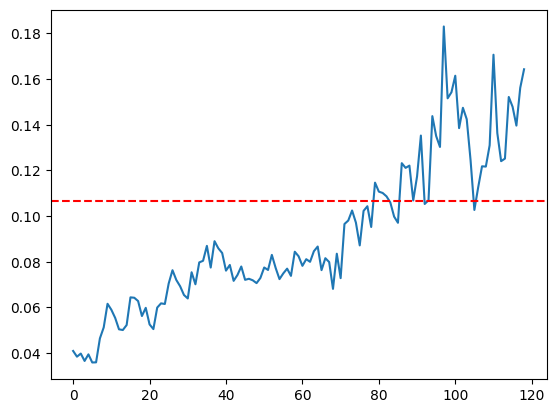

In [5]:
features, _ = reader.load_split("dev")
health_indicator = rul_adapt.approach.latent_align.get_health_indicator(
    approach, features[0], 5, 256
)
threshold = 2.5 * health_indicator[:10].mean()
plt.plot(health_indicator)
plt.axhline(threshold, color="red", linestyle="--")
plt.show()

The following function can be used for conveniently calculating the FTTP for a given bearing.

In [6]:
fttp = rul_adapt.approach.latent_align.get_first_time_to_predict(
    approach,
    features[0],
    window_size=5,
    chunk_size=256,
    healthy_index=15,
    threshold_coefficient=2.5
)
print(f"FTTP of Bearing 1-1: {fttp}")

FTTP of Bearing 1-1: 83


## Reproduce original configurations

You can reproduce the original experiments of Zhang et al. by using the `get_latent_align` constructor function.
Known differences to the original paper:

* The healthy state cutoff for FTTP estimation was set to 15 because none was given in the paper.
* The threshold coefficient for FTTP estimation was set to 2.5 because none was given in the paper.
* The generator architecture for FTTP estimation was altered as we found no way to make the one from the paper work.

In this example we re-create the configuration for adapting CMAPSS FD003 to FD001.
Additional kwargs for the trainer, e.g. `accelerator="gpu"` for training on a GPU, can be passed to the function, too.


In [7]:
pl.seed_everything(42)  # make reproducible
dm, latent, trainer = rul_adapt.construct.get_latent_align("cmapss", 3, 1, max_epochs=1)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The networks, `feature_extractor` and `regressor`, can be accessed as properties of the `latent` object.

In [8]:
latent.feature_extractor

CnnExtractor(
  (_layers): Sequential(
    (conv_0): Sequential(
      (0): Conv1d(14, 32, kernel_size=(3,), stride=(1,), padding=valid)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (conv_1): Sequential(
      (0): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=valid)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (conv_2): Sequential(
      (0): Conv1d(16, 1, kernel_size=(3,), stride=(1,), padding=valid)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (3): Flatten(start_dim=1, end_dim=-1)
    (fc): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=24, out_features=256, bias=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
)

Training is done in the PyTorch Lightning fashion. We used the `trainer_kwargs` to train only one epoch for demonstration purposes.

In [9]:
trainer.fit(latent, dm)
trainer.test(latent, dm)


  | Name               | Type                               | Params
--------------------------------------------------------------------------
0 | train_mse          | MeanSquaredError                   | 0     
1 | healthy_align      | HealthyStateAlignmentLoss          | 0     
2 | direction_align    | DegradationDirectionAlignmentLoss  | 0     
3 | level_align        | DegradationLevelRegularizationLoss | 0     
4 | fusion_align       | MaximumMeanDiscrepancyLoss         | 0     
5 | evaluator          | AdaptionEvaluator                  | 0     
6 | _feature_extractor | CnnExtractor                       | 9.4 K 
7 | _regressor         | FullyConnectedHead                 | 257   
--------------------------------------------------------------------------
9.6 K     Trainable params
0         Non-trainable params
9.6 K     Total params
0.039     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    test/source/rmse         83.4994888305664
    test/source/score           368967.1875
    test/target/rmse                                  84.54061889648438
    test/target/score                                     340130.5
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/source/rmse/dataloader_idx_0': 83.4994888305664,
  'test/source/score/dataloader_idx_0': 368967.1875},
 {'test/target/rmse/dataloader_idx_1': 84.54061889648438,
  'test/target/score/dataloader_idx_1': 340130.5}]

If you only want to see the hyperparameters, you can use the `get_latent_align_config` function.
This returns an `omegaconf.DictConfig` which you can modify.

In [10]:
three2one_config = rul_adapt.construct.get_latent_align_config("cmapss", 3, 1)
print(omegaconf.OmegaConf.to_yaml(three2one_config, resolve=True))

dm:
  source:
    _target_: rul_datasets.CmapssReader
    fd: 3
    window_size: 30
  target:
    _target_: rul_datasets.CmapssReader
    fd: 1
    window_size: 30
    percent_broken: 1.0
  kwargs:
    batch_size: 128
  adaption_kwargs:
    inductive: true
    split_by_steps: 80
feature_extractor:
  _convert_: all
  _target_: rul_adapt.model.CnnExtractor
  input_channels: 14
  units:
  - 32
  - 16
  - 1
  seq_len: 30
  fc_units: 256
  fc_dropout: 0.5
  act_func: torch.nn.LeakyReLU
  fc_act_func: torch.nn.LeakyReLU
regressor:
  _convert_: all
  _target_: rul_adapt.model.FullyConnectedHead
  input_channels: 256
  act_func_on_last_layer: false
  units:
  - 1
latent_align:
  _target_: rul_adapt.approach.LatentAlignApproach
  alpha_healthy: 1.0
  alpha_direction: 1.0
  alpha_level: 1.0
  alpha_fusion: 1.0
  labels_as_percentage: true
  lr: 0.0005
trainer:
  _target_: pytorch_lightning.Trainer
  max_epochs: 2000


## Run your own experiments

You can use the Latent Alignment implementation to run your own experiments with different hyperparameters or on different datasets.
Here we adapt from FD001 to FD003 of XJTU-SY which is missing from the original paper.

In [2]:
source = rul_datasets.XjtuSyReader(
    1,
    first_time_to_predict=[100] * 5,  # dummy values
    norm_rul=True,
    run_split_dist={"dev": [1, 2, 3, 4, 5], "val": [], "test": []}
)
target = rul_datasets.XjtuSyReader(
    3,
    percent_broken=0.5,
    truncate_degraded_only=True,
    first_time_to_predict=[100] * 5,  # dummy values
    norm_rul=True,
    run_split_dist={"dev": [3], "val": [], "test": [3]},
)
extractor = rul_adapt.approach.latent_align.ChunkWindowExtractor(5, 256)
dm = rul_datasets.LatentAlignDataModule(
    rul_datasets.RulDataModule(source, 128, extractor),
    rul_datasets.RulDataModule(target, 128, extractor),
    split_by_max_rul=True,
    inductive=True,
)

feature_extractor = rul_adapt.model.CnnExtractor(
    2,
    [32, 16, 1],
    1280,
    fc_units=256,
    fc_dropout=0.5,
    act_func=torch.nn.LeakyReLU,
    fc_act_func=torch.nn.LeakyReLU,
)

regressor = rul_adapt.model.FullyConnectedHead(256, [1], act_func_on_last_layer=False)

latent = rul_adapt.approach.LatentAlignApproach(1.0, 1.0, 1.0, 1.0, lr=5e-4)
latent.set_model(feature_extractor, regressor)

trainer = pl.Trainer(max_epochs=1)

trainer.fit(latent, dm)
trainer.test(latent, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name               | Type                               | Params
--------------------------------------------------------------------------
0 | train_mse          | MeanSquaredError                   | 0     
1 | healthy_align      | HealthyStateAlignmentLoss          | 0     
2 | direction_align    | DegradationDirectionAlignmentLoss  | 0     
3 | level_align        | DegradationLevelRegularizationLoss | 0     
4 | fusion_align       | MaximumMeanDiscrepancyLoss         | 0     
5 | evaluator          | AdaptionEvaluator                  | 0     
6 | _feature_extractor | CnnExtractor                       | 328 K 
7 | _regressor         | FullyConnectedHead                 | 257   
--------------------------------------------------------------------------
328 K     Trainable params
0         Non-trainable params
328 K     Total params


Sanity Checking: 0it [00:00, ?it/s]

/home/tilman/Programming/rul-adapt/.venv/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:109: UserWarning: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
/home/tilman/Programming/rul-adapt/.venv/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:109: UserWarning: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/tilman/Programming/rul-adapt/.venv/lib/python3.8/site-packages/lightning_fabric/utilities/data.py:55: UserWarning: `DataLoader` returned 0 length. Please make sure this was your intention.
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    test/target/rmse                                 0.3762059807777405
    test/target/score                                 1309.618896484375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{},
 {'test/target/rmse/dataloader_idx_1': 0.3762059807777405,
  'test/target/score/dataloader_idx_1': 1309.618896484375}]